In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
import sys
sys.path.append("..")

import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import train_and_return_losses, TrainState
from dots.models import MLP
from dots.dots import *

# Training with base functions

In [70]:
model = MLP(1, 1, hidden = 4, hidden_size = 12)
N = 256
N_test = 64
x = rearrange(t.linspace(0, 8, N), "x -> x 1")
y = t.sin(x)

t.manual_seed(42)
dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [71]:
train_losses, test_losses = np.array([]), np.array([])
train_xs, test_xs = np.array([]), np.array([])

In [62]:
(add_train_xs, add_train_losses), (add_test_xs, add_test_losses) = train_and_return_losses(
    model,
    t.optim.Adam(model.parameters(), lr=1e-4),
    t.nn.MSELoss(),
    train_dataloader,
    test_dataloader,
    epochs=300
)

train_losses = np.concatenate([train_losses, add_train_losses])
test_losses = np.concatenate([test_losses, add_test_losses])
current = train_xs.shape[0]
train_xs = np.concatenate([train_xs, add_train_xs + current])
test_xs = np.concatenate([test_xs, add_test_xs + current])

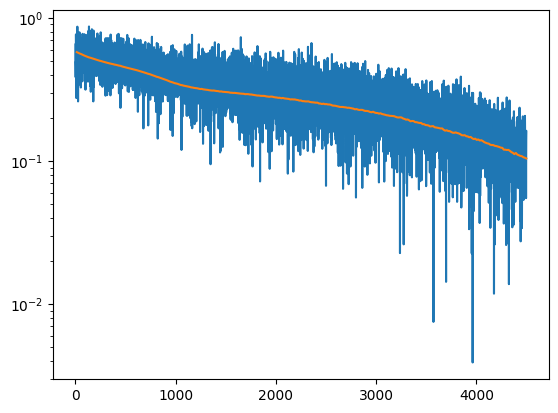

In [63]:
plt.plot(train_xs, train_losses)
plt.plot(test_xs, test_losses)
plt.yscale("log")

In [56]:
x = t.linspace(-2, 10, 1000)
model_outs = model(x.unsqueeze(-1)).detach()

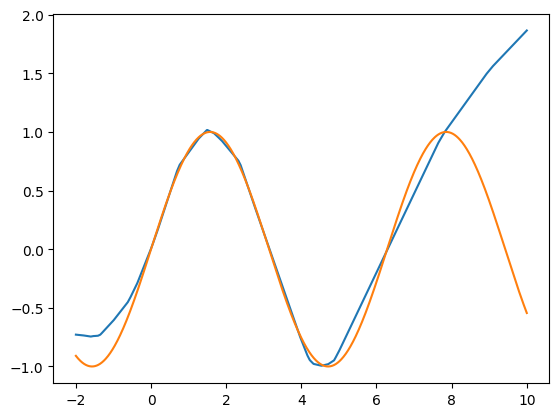

In [57]:
plt.plot(x, model_outs)
plt.plot(x, t.sin(x))


# DOTS approximation tests

In [43]:
x = t.linspace(0, 4, 1000).unsqueeze(dim=-1)
model.count_params()

505

In [44]:
model.singular_value_rank(x)

tensor(5.2907)

In [45]:
model.jacobian_matrix_rank(x)

tensor(25)

In [47]:
t.linalg.svd(model.matrix_jacobian(x)).S.shape

torch.Size([505])

In [49]:
t.exp(entropy(t.linalg.svd(matrix_jacobian(model, x)).S))

tensor(5.2907)

In [50]:
model.singular_value_rank(x)

tensor(5.2907)

# Training with TrainState

In [132]:
# copied from above:
model = MLP(1, 1, hidden = 4, hidden_size = 12)
N = 256
N_test = 64
x = rearrange(t.linspace(0, 8, N), "x -> x 1")
y = t.sin(x)

t.manual_seed(42)
dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=16, shuffle=True)

# NEW
trainstate = TrainState(
    model=model,
    optimiser=t.optim.Adam(model.parameters(), lr=1e-4),
    loss_fn=t.nn.MSELoss(),
    dataloader=train_dataloader,
    test_loader=test_dataloader,
    hooks=[]
)

In [133]:
trainstate.train(100)

  0%|          | 0/100 [00:00<?, ?it/s]

0

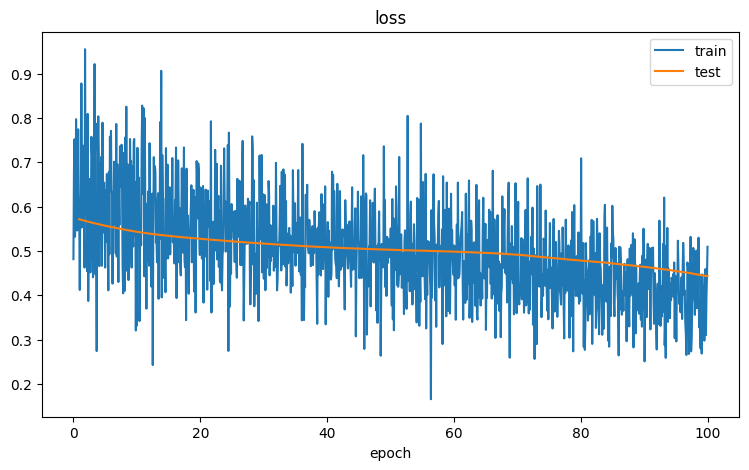

In [134]:
trainstate.plot()